Importing all the necessary libraries and login to the wandb

In [1]:
!pip install wandb
import wandb
wandb.login()
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=90055601082664faaf89da445159373621575de6aff74385805d907036747e37
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Importing the Dataset and displaying sample images randomly chosen each time

4422102/4422102 [==============================] - 0s 0us/step
___________________________________________________________________
Dataset loaded successfully!
Dataset contains Training data of size: 60000
Dataset contains Test data of size: 10000
Number of classes in the dataset:10
___________________________________________________________________
The Dataset contains the following classes:
T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
___________________________________________________________________
Displaying a random image from each of the classes:


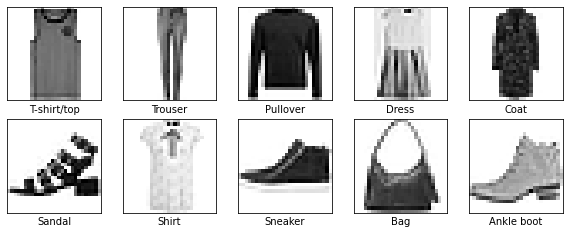

wandb: Currently logged in as: cs22m025. Use `wandb login --relogin` to force relogin


In [2]:
from keras.datasets import fashion_mnist

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
#normalising the dataset
X_train=X_train/255

#getting to know about the dataset
print("___________________________________________________________________")

print("Dataset loaded successfully!")

print("Dataset contains Training data of size:",Y_train.shape[0])
print("Dataset contains Test data of size:",Y_test.shape[0])
print("Number of classes in the dataset:10")

print("___________________________________________________________________")
#referred from the fashion mnist document
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("The Dataset contains the following classes:")
for i in range(10):
  print(class_labels[i])


def display_sampleimage():
    ans = [-1 for i in range(10)]
    count=0
    while 1:
      #randomly choosing an image from the dataset
      i=random.randint(0,len(Y_train)-1)
      #checks whether there is an image from the same class on sample iamges
      if (ans[Y_train[i]])==-1:
        ans[Y_train[i]]=i
        count+=1
      if count==10:
        break

    print("___________________________________________________________________")
    print("Displaying a random image from each of the classes:")
    images_list=[]
    class_list=[]
    figure(figsize=(10, 10))
    logs=[]

    #plotting the sample images
    for i in range(10):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      j=ans[i]
      plt.imshow(X_train[j], cmap=plt.cm.binary)
      
      plt.xlabel(class_labels[i])
      images_list.append(X_train[j])
      class_list.append(class_labels[Y_train[j]])
      log_images=wandb.Image(X_train[j] , caption=class_labels[Y_train[j]])
      logs.append(log_images)
    plt.show()


    #passing the sample images to wandb
    run=wandb.init(project="assignment1",entity="cs22m025")
    wandb.log({"Sample Images": logs})
    run.finish()

#function call to display sample images
display_sampleimage()

Splitting into train and validation data further

In [3]:
X=X_train
Y=Y_train

print("Splitting the Training dataset into training and validation data........")
from sklearn.model_selection import train_test_split
#splitting in ratio 9:1 (train:validation)
X_train,X_validate,Y_train,Y_validate=train_test_split(X, Y, test_size=0.1, random_state=42)
print("Dataset contains Training data of size:",Y_train.shape[0])
print("Dataset contains validation data of size:",Y_validate.shape[0])


Splitting the Training dataset into training and validation data........
Dataset contains Training data of size: 54000
Dataset contains validation data of size: 6000


In [4]:

#here W the overall weigth matrix of the model and is a 3D matrix which is a collection of 2D matrix for each layer
#b is the overall bias matrix which is a collection of bias vector for each layer


def random_initialisation(n_hidden,n_neurons,n_inputneurons,n_outputneurons):
  sd=0.5
  #initalising to small values as the initilaising has an important effect on training, and initialising to large values will not lead to good model
  W=[np.random.normal(0,sd,(n_neurons,n_inputneurons)) if i==0  else np.random.normal(0,sd,(n_neurons,n_neurons)) for i in range(n_hidden)]
  Wo=np.random.normal(0,sd,(n_outputneurons,n_neurons))
  W.append(Wo)
  b=[np.random.normal(0,sd,(n_outputneurons,1)) if i==n_hidden else np.random.normal(0,sd,(n_neurons,1)) for i in range(n_hidden+1)]

  return (W,b)



def xavier_initialisation(n_hidden,n_neurons,n_inputneurons,n_outputneurons):
  W=[np.random.randn(n_neurons,n_inputneurons)*np.sqrt(2/(n_neurons+n_inputneurons)) if i==0  else np.random.randn(n_neurons,n_neurons)*np.sqrt(2/(n_neurons+n_neurons)) for i in range(n_hidden)]
  Wo=np.random.randn(n_outputneurons,n_neurons)*np.sqrt(2/(n_outputneurons+n_neurons))
  W.append(Wo)
  b=[np.random.randn(n_outputneurons,1) if i==n_hidden else np.random.randn(n_neurons,1) for i in range(n_hidden+1)]

  return (W,b)

#initiliasing u matrix for both W and b as zero matrix for all the layers
def initialise_u(n_hidden,n_neurons,n_inputneurons,n_outputneurons):
  u_W=[np.zeros((n_neurons,n_inputneurons)) if i==0  else np.zeros((n_neurons,n_neurons)) for i in range(n_hidden)]
  u_Wo=np.zeros((n_outputneurons,n_neurons))
  u_W.append(u_Wo)
  u_b=[np.zeros((n_outputneurons,1)) if i==n_hidden else np.zeros((n_neurons,1)) for i in range(n_hidden+1)]

  return (u_W,u_b)    

def initialise_modelparameters(initialisation,n_hidden,n_neurons,n_inputneurons,n_outputneurons):

  if(initialisation=="random"):
    return random_initialisation(n_hidden,n_neurons,n_inputneurons,n_outputneurons)

  elif(initialisation=="xavier"):
    return xavier_initialisation(n_hidden,n_neurons,n_inputneurons,n_outputneurons)


def relu(x):
  return np.maximum(x,0)


def sigmoid(x):
  return 1. / (1.+np.exp(-x)) 

def softmax(x):
  e_X = np.exp(x - np.max(x, axis = 0))
  return e_X / (e_X.sum(axis = 0)+1e-8)  #small value added to prevent divide by zero case

def tanh(x):
  return np.tanh(x)


def activation(activation_function,a,n_neurons):
  if activation_function == 'sigmoid':
        h=sigmoid(a)
  elif activation_function == 'relu':
          h=relu(a)
  elif activation_function == 'tanh':
          h=tanh(a)
  return h



def forwardPropagation(W,b,n_neurons,n_layers,activation_function,X,n_outputneurons):
  ''' W, b are the parameters
  n_neurons is the number of nuerons in every hidden layer
  n_layers is the number of hidden layer
  X is the train dataset'''
  a=np.zeros((n_neurons,X.shape[1]))
  h=X
  H=[]
  A=[]

  for k in range(0,n_layers):
    a=b[k]+np.matmul(W[k],h)
    h=activation(activation_function,a,n_neurons)
    H.append(h)
    A.append(a)
    
 
  a=b[n_layers]+(np.matmul(W[n_layers],h)) # activation function for output layer

  y=softmax(a)
  H.append(y)
  A.append(a)
  
  #wrapping all the values as a dictionary
  return { "A" :A, "H":H, "y":y}


trainData=[X_train[i].flatten() for i in range(X_train.shape[0])]
trainData=np.transpose(trainData)



In [5]:
xval_flat=[X_validate[i].flatten() for i in range(X_validate.shape[0])]
xval=np.transpose(xval_flat)

In [6]:
def one_hot_vector(Y_t,lenY):
  y_temp=np.zeros((10, lenY))
  for i in range(lenY):
    ans=Y_t[i]
    y_temp[ans][i]=1
  return y_temp

#defining one hot vectors for both train and validation data
y_one=one_hot_vector(Y_train,Y_train.shape[0])
y_one_val=one_hot_vector(Y_validate,Y_validate.shape[0])


def element_wise_multiply(A,B):
  C=np.zeros(len(A))
  for i in range(len(A)):
    C[i]=A[i]*B[i]
  return C.T

def sigmoid_derivative(x):
  return sigmoid(x) * (1-sigmoid(x))

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def relu_derivative(x):
  return x>0


def find_derivative(activation_function,h,n_neurons):
  
  if(activation_function=="sigmoid"):
      g=sigmoid(h)*(1-sigmoid(h))

  elif(activation_function=="tanh"):
      g= tanh_derivative(h)
      
  elif(activation_function=="relu"):
      g=relu_derivative(h)
  
  return g
  
  

def backPropagation(H,A,n_neurons,n_layers,truelabel,n_classes,W,activation_function,X,y_one,wgt_dec,loss_fn):
  ''' W, b are the parameters
  n_neurons is the number of nuerons in every hidden layer
  n_layers is the number of hidden layer
  X is the train dataset
  wgt_dec is the weigth decay
  y_one is the one hot matrix'''

  gradient_a=H[n_layers]-y_one
  if(loss_fn=='mean_squared_error'):
    gradient_a*=H[n_layers]*(1-H[n_layers])

  G_W=[]
  G_b=[]
  
  for k in range(n_layers,-1,-1):
   
    if(k==0):
     
      gradient_W=np.matmul(gradient_a,X.T)+wgt_dec*W[k]/X.shape[1]
      G_W.append(gradient_W)
    else:
      gradient_W=np.matmul(gradient_a,H[k-1].T)+wgt_dec*W[k]/X.shape[1]
      G_W.append(gradient_W)
    gradient_b=np.sum(gradient_a, axis=1, keepdims=True) / X.shape[1]
    G_b.append(gradient_b)
    
    if(k>0):
      gradient_prevh=np.matmul(W[k].T,gradient_a)
      derivative_matrix=find_derivative(activation_function,H[k-1],n_neurons)
      gradient_a=gradient_prevh*derivative_matrix
    
 
  G_W=G_W[::-1]
  G_b=G_b[::-1]
  return {"g_W": G_W, "g_b": G_b}





In [7]:
with np.errstate(divide="ignore"):
    np.log(0)

Accuracy function

In [8]:
def calc_accuracy(prd,Y):
  y_pred = np.argmax(prd["y"],axis=0)
  accuracy = np.sum(y_pred==Y)/Y.shape[0]
  return accuracy



Stochastic gradient descent which 
when given a batch size act as mini batch gradient descent, 
when batch size=1 act as stochastic gradient descent,
when batch size=whole datasize acts as gradient descent

In [9]:
from tempfile import tempdir
from matplotlib import tempfile

def gradient_update_vanila(W,b,n_layers,grad,eta):

  for k in range(0,n_layers+1):
    W[k]-=eta*grad["g_W"][k]
    b[k]=b[k]-eta*grad["g_b"][k]

  return (W,b)

#calculating both training and validation loss
def calculateloss(y_t_predicted,batch_size,lenx,leny,Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,isvalidate=False,y_v_predicted=None,Y_val=None):

  if(loss_fn=='cross_entropy'):
    temp=np.arange(leny)
    y_t_predicted = np.maximum(y_t_predicted, 1e-10)
    l= sum(-np.log(y_t_predicted.T[temp,Y]))/lenx

  elif(loss_fn=='mean_squared_error'):
    l=np.mean(np.square(y_one - y_t_predicted))
  #regularisation
  mod=0
  if(wgt_dec!=0):
    for k in range(0,n_layers+1):
      mod+=np.sum(W[k]**2)
  training_loss= l+((wgt_dec*mod)/(2*lenx))

  #if validation loss is also to be calculated
  if(isvalidate):

    if(loss_fn=='cross_entropy'):
      temp=np.arange(6000)
      y_v_predicted = np.maximum(y_v_predicted, 1e-10)
      l= sum(-np.log(y_v_predicted.T[temp,Y_val]))/6000
    elif(loss_fn=='mean_squared_error'):
      l=np.mean(np.square(y_one_val - y_v_predicted))

    validation_loss=l+((wgt_dec*mod)/(2*6000))
    return training_loss,validation_loss

  return training_loss



#stochastic gradient descent
def modelfit_gradient_descent(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  Loss=[]
  v_loss=[]

  print("___________________________________________________________________")
  print("Running Stochastic Gradient Descent.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")
  for t in range(epoch):
    
    for i in range(0,X.shape[1],batch_size):
      y_f=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y_f["H"],y_f["A"],n_neurons,n_layers,Y_train,n_classes,W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)   
      (W,b)=gradient_update_vanila(W,b,n_layers,g,eta)
   
    #calculating model performance
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})


  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)

  return(W,b,Loss,v_loss)



#to run individually
#run=wandb.init(project="assignment1")
#(W,b,Loss,v_loss)=modelfit_gradient_descent(5,1e-3,3,"relu",32,"xavier",784,10,trainData,Y_train,10,32,0.0005,"cross_entropy")
#run.finish()


Plotting loss function

In [10]:
def plotLoss(epochs,Loss,v_loss):
  plt.plot(epochs,Loss,label="Training loss")
  plt.plot(epochs,v_loss,label="Validation loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()



In [11]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Momentum based gradient descent

In [12]:
def gradient_update_momentum(W,b,n_layers,grad,eta,u_W,u_b,beta):
  for k in range(0,n_layers+1):
    u_W[k]=beta*u_W[k]+(1-beta)*grad["g_W"][k]
    W[k]=W[k]-(eta*u_W[k])
    u_b[k]=beta*u_b[k]+(1-beta)*grad["g_b"][k]
    b[k]=b[k]-(eta*u_b[k])

  return (u_W,W,u_b,b)




def modelfit_momentum(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (u_W,u_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  Loss=[]
  v_loss=[]
  print("___________________________________________________________________")
  print("Running Mometum Based Gradient Descent.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")
  for t in range(epoch):
    
    for i in range(0,X.shape[1],batch_size):

      y=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y["H"],y["A"],n_neurons,n_layers,Y_train,n_classes,W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)
      (u_W,W,u_b,b)=gradient_update_momentum(W,b,n_layers,g,eta,u_W,u_b,beta)
  
    #calculating model performance
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})
  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)
    
  return (Loss,W,b,v_loss)

#to run individually
run=wandb.init(project="assignment1",entity="cs22m025")
(Loss,W,b,v_loss)=modelfit_momentum(5,1e-3,5,"tanh",32,"xavier",784,10,trainData,Y_train,10000,0.9,32,0.0005,"cross_entropy")
run.finish()

___________________________________________________________________
Running Mometum Based Gradient Descent.....
epoch        training loss         validation loss               
0         0.48180919492967456      0.49014005955216267           
1         0.42987957107955044      0.4393917207745242            
2         0.41076978637817774      0.4211291594407801            
3         0.40726574064066473      0.42334218633746656           
4          0.4081514817702583      0.42887613621191706           
------------------------------------------------------------------
Accuracy on training data: 0.8557037037037037
Accuracy on validation data: 0.8481666666666666


epoch,▁▃▅▆█
training_accuracy,▁▆███
training_loss,█▃▁▁▁
validation_accuracy,▁▆█▇▆
validation_loss,█▃▁▁▂
epoch,4
training_accuracy,0.8557
training_loss,0.40815
validation_accuracy,0.84817
validation_loss,0.42888


Nesterov Accelerated Gradient descent

In [13]:
def gradient_update_nesterov(W,b,n_layers,grad,eta,u_W,u_b,beta):
  for k in range(0,n_layers+1):
    u_W[k]=beta*u_W[k]+eta*grad["g_W"][k]
    W[k]-=(u_W[k])
    u_b[k]=beta*u_b[k]+eta*grad["g_b"][k]
    b[k]-=(u_b[k])

  return (u_W,W,u_b,b)



def modelfit_nestrov(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (u_W,u_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  lookahead_W=W.copy()
  lookahead_b=b.copy()
  Loss=[]
  v_loss=[]
  print("___________________________________________________________________")
  print("Running Nesterov Accelerated Based Gradient Descent.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")

  for t in range(epoch):
   
    sum=0
    loss=0
    for k in range(0,n_layers+1):
      u_W[k]=beta*u_W[k]
      u_b[k]=beta*u_b[k]
    for i in range(0,X.shape[1],batch_size):

      for k in range(0,n_layers+1):
        lookahead_W[k]=W[k]-u_W[k]
        lookahead_b[k]=b[k]-u_b[k]
      y=forwardPropagation(lookahead_W,lookahead_b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y["H"],y["A"],n_neurons,n_layers,Y_train,n_classes,lookahead_W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)
      (u_W,W,u_b,b)=gradient_update_nesterov(W,b,n_layers,g,eta,u_W,u_b,beta)
      
    #calculating model performance
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})

  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)
    
  return (Loss,W,b,v_loss)

#to run individually
#run=wandb.init(project="assignment1",entity="cs22m025")
#(Loss,W,b,v_loss)=modelfit_nestrov(5,1e-3,3,"relu",128,"xavier",784,10,trainData,Y_train,10,0.9,64,0.0005,"cross_entropy")
#run.finish()

RMSProp

In [14]:
def gradient_update_rmsprop(W,b,n_layers,grad,eta,v_W,v_b,beta,epsilon):
  for k in range(0,n_layers+1):
    v_W[k]=beta*v_W[k]+(1-beta)*(np.multiply(grad["g_W"][k],grad["g_W"][k]))
    W[k]-=(eta*grad["g_W"][k])/(np.sqrt(v_W[k])+epsilon)
    v_b[k]=beta*v_b[k]+(1-beta)*(np.multiply(grad["g_b"][k],grad["g_b"][k]))
    b[k]-=(eta*grad["g_b"][k])/(np.sqrt(v_b[k])+epsilon)

  return (v_W,W,v_b,b)




def modelfit_rmsprop(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,epsilon,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (v_W,v_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  Loss=[]
  v_loss=[]
  print("___________________________________________________________________")
  print("Running RMSProp.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")

  for t in range(epoch):
    
    for i in range(0,X.shape[1],batch_size):

      y=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y["H"],y["A"],n_neurons,n_layers,Y_train,n_classes,W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)
      (v_W,W,v_b,b)=gradient_update_rmsprop(W,b,n_layers,g,eta,v_W,v_b,beta,epsilon)
  
    #calculating model performance
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
    
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})

  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)


  return (Loss,W,b,v_loss)

#to run individually
#run=wandb.init(project="assignment1",entity="cs22m025")
#(Loss,W,b,v_loss)=modelfit_rmsprop(5,1e-3,5,"relu",128,"random",784,10,trainData,Y_train,10,0.9,1e-6,16,0,"cross_entropy")
#run.finish()

Adam

In [15]:
def gradient_update_adam(W,b,n_layers,grad,eta,v_W,v_b,m_W,m_b,beta1,beta2,epsilon,t):
  for k in range(0,n_layers+1):
    m_W[k]=beta1*m_W[k]+(1-beta1)*grad["g_W"][k]
    m_b[k]=beta1*m_b[k]+(1-beta1)*grad["g_b"][k]

    v_W[k]=beta2*v_W[k]+(1-beta2)*grad["g_W"][k]**2
    v_b[k]=beta2*v_b[k]+(1-beta2)*grad["g_b"][k]**2

    m_W_correction=m_W[k]/(1-(beta1**t))
    m_b_correction=m_b[k]/(1-(beta1**t))

    v_W_correction=v_W[k]/(1-(beta2**t))
    v_b_correction=v_b[k]/(1-(beta2**t))

    W[k]-=(eta*m_W_correction)/(np.sqrt(v_W_correction)+epsilon)
    b[k]-=(eta*m_b_correction)/(np.sqrt(v_b_correction)+epsilon)

  return (m_W,v_W,W,m_b,v_b,b)




def modelfit_adam(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta1,beta2,epsilon,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (v_W,v_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (m_W,m_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  v_loss=[]
  Loss=[]
  print("___________________________________________________________________")
  print("Running Adam.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")

  for t in range(1,epoch+1):
    
    for i in range(0,X.shape[1],batch_size):

      y=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y["H"],y["A"],n_neurons,n_layers,Y_train,n_classes,W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)
      (m_W,v_W,W,m_b,v_b,b)=gradient_update_adam(W,b,n_layers,g,eta,v_W,v_b,m_W,m_b,beta1,beta2,epsilon,t)
  
    #calculating the model performance
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
  
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})

  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)
  return (Loss,W,b,v_loss)


#to run individually
#run=wandb.init(project="assignment1",entity="cs22m025")
#(Loss,W,b,v_loss)=modelfit_adam(10,1e-3,3,"tanh",32,"xavier",784,10,trainData,Y_train,10,0.9,0.999,1e-8,10,0.0005,"cross_entropy")
#run.finish()

Nadam

In [16]:
def gradient_update_nadam(W,b,n_layers,grad,eta,v_W,v_b,m_W,m_b,beta1,beta2,epsilon,t):
  for k in range(0,n_layers+1):
    m_W[k]=beta1*m_W[k]+(1-beta1)*grad["g_W"][k]
    m_b[k]=beta1*m_b[k]+(1-beta1)*grad["g_b"][k]

    v_W[k]=beta2*v_W[k]+(1-beta2)*grad["g_W"][k]**2
    v_b[k]=beta2*v_b[k]+(1-beta2)*grad["g_b"][k]**2

    m_W_correction=m_W[k]/(1-(beta1**(t+1)))
    m_b_correction=m_b[k]/(1-(beta1**(t+1)))

    v_W_correction=v_W[k]/(1-(beta2**(t+1)))
    v_b_correction=v_b[k]/(1-(beta2**(t+1)))

    W[k]-=((eta)/(np.sqrt(v_W_correction)+epsilon))*(beta1*m_W_correction+((1-beta1)*grad["g_W"][k])/(1-beta1**(t+1)))
    b[k]-=(eta)/(np.sqrt(v_b_correction)+epsilon)*(beta1*m_b_correction+((1-beta1)*grad["g_b"][k])/(1-beta1**(t+1)))

  return (m_W,v_W,W,m_b,v_b,b)




def modelfit_nadam(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta1,beta2,epsilon,batch_size,wgt_dec,loss_fn):

  (W,b)=initialise_modelparameters(initialisation,n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (v_W,v_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  (m_W,m_b)=initialise_u(n_layers,n_neurons,n_inputneurons,n_outputneurons)
  Loss=[]
  v_loss=[]
  print("___________________________________________________________________")
  print("Running Nadam.....")
  print(f"{'epoch': <5}{'training loss' : ^30}{'validation loss ': <30}")

  for t in range(1,epoch+1):
    
    for i in range(0,X.shape[1],batch_size):

      y=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,trainData[:,i:i+batch_size],10)
      g=backPropagation(y["H"],y["A"],n_neurons,n_layers,Y_train,n_classes,W,activation_fn,trainData[:,i:i+batch_size],y_one[:,i:i+batch_size],wgt_dec,loss_fn)
      (m_W,v_W,W,m_b,v_b,b)=gradient_update_nadam(W,b,n_layers,g,eta,v_W,v_b,m_W,m_b,beta1,beta2,epsilon,t)
  
    #calculating model performance  
    y_t=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,X,10)
    y_v=forwardPropagation(W,b,n_neurons,n_layers,activation_fn,xval,10)
    (training_loss,validation_loss)=calculateloss(y_t["y"],batch_size,len(X.T),len(Y),Y,wgt_dec,n_layers,W,loss_fn,y_one,y_one_val,True,y_v["y"],Y_validate)
    training_accuracy=calc_accuracy(y_t,Y_train)
    validation_accuracy=calc_accuracy(y_v,Y_validate)
    
    print(f"{t : <5}{training_loss : ^30}{validation_loss : <30}")
    Loss.append(training_loss)
    v_loss.append(validation_loss)
    #logging the values to wandb
    wandb.log({"validation_loss": validation_loss,"validation_accuracy": validation_accuracy,"training_loss": training_loss,"training_accuracy": training_accuracy, 'epoch': t})

  print("------------------------------------------------------------------")
  print("Accuracy on training data:",training_accuracy)
  print("Accuracy on validation data:",validation_accuracy)

  return (Loss,W,b,v_loss)

#to run individually
#run=wandb.init(project="assignment1",entity="cs22m025")
#(Loss,W,b,v_loss)=modelfit_nadam(5,1e-3,5,"relu",128,"random",784,10,trainData,Y_train,10,0.9,0.999,1e-8,32,0.0005,"cross_entropy")
#run.finish()

In [47]:
#function which wraps up all the optimisers

def network_train(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,X,Y,batch_size,wgt_dec,optimiser,n_inputneurons,n_outputneurons,n_classes,beta,beta1,beta2,epsilon,loss_fn):
  ''' W, b are the parameters
  n_neurons is the number of nuerons in every hidden layer
  n_layers is the number of hidden layer
  X , Y is the train dataset'''
  if(optimiser=="sgd"):
    (W,b,Loss,v_loss)=modelfit_gradient_descent(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,batch_size,wgt_dec,loss_fn)
  elif optimiser=="momentum":
    (Loss,W,b,v_loss)=modelfit_momentum(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,batch_size,wgt_dec,loss_fn)
  elif optimiser=="nag":
    (Loss,W,b,v_loss)=modelfit_nestrov(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,batch_size,wgt_dec,loss_fn)
  elif optimiser=="rmsprop":
    (Loss,W,b,v_loss)=modelfit_rmsprop(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta,epsilon,batch_size,wgt_dec,loss_fn)
  elif optimiser=="adam":
    (Loss,W,b,v_loss)=modelfit_adam(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta1,beta2,epsilon,batch_size,wgt_dec,loss_fn)
  elif optimiser=="nadam":
    (Loss,W,b,v_loss)=modelfit_nadam(epoch,eta,n_layers,activation_fn,n_neurons,initialisation,n_inputneurons,n_outputneurons,X,Y,n_classes,beta1,beta2,epsilon,batch_size,wgt_dec,loss_fn)

  epochs=[i for i in range(epoch)]
  plotLoss(epochs,Loss,v_loss)
  return (Loss,W,b,v_loss)



___________________________________________________________________
Running Adam.....
epoch        training loss         validation loss               
1          0.3806266299425122      0.38819549032210593           
2         0.34184474487678335      0.3567711086700468            
3         0.31766098163344497      0.3401117336604542            
4         0.29981196900419943      0.3290888195388087            
5         0.28649189485597354      0.32199115731543276           
6          0.2751039429252497      0.31803367268796195           
7          0.2650180943969341      0.3149013384989146            
8          0.2560854069865765      0.3127083318774143            
9         0.24857570316787833      0.31179145446199985           
10        0.24071243989711197      0.30984805062415594           
------------------------------------------------------------------
Accuracy on training data: 0.9102962962962963
Accuracy on validation data: 0.8878333333333334


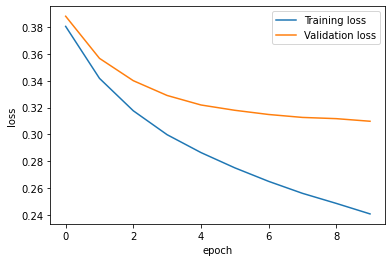

epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
training_accuracy,0.9103
training_loss,0.24071
validation_accuracy,0.88783
validation_loss,0.30985


In [45]:
#running on best configuration
run=wandb.init(project="assignment1")
wandb.run.name="cross entropy"
(Loss,W,b,v_loss)=network_train(10,1e-3,3,"relu",128,"xavier",trainData,Y_train,32,0,"adam",784,10,10,0.9,0.9,0.999,1e-8,"cross_entropy")
run.finish()

Sweep function

In [19]:
#SWEEP CONFIGURATION
sweep_config = {
    'method': 'random',     
    'metric': { 'name': 'validation_accuracy', 'goal': 'maximize'},
    'parameters': {'epoch': {'values': [5, 10] } ,
                   'n_neurons': { 'values': [32, 64, 128] },
                  'n_layers':{ 'values':[3,4,5]  },
                   'eta': {  'values': [1e-3, 1e-4]},
                  'optimizer': { 'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam' ]},
                  'batch_size': {'values': [16, 32, 64] },
                  'initialisation': { 'values': ['random', 'xavier']  },
                   'activation_fn': {  'values': ['relu', 'tanh', 'sigmoid']  },
                   'wgt_dec' :{   'values': [0, 0.0005, 0.5]  }
                   },
    
  }

def train():
    run=wandb.init(project="assignment1",entity="cs22m025")
    config = wandb.config
    #took reference from wandb document
    wandb.run.name="ep_{}_hl_{}_nn_{}_lr_{}_ac_{}_op_{}_in_{}_bs_{}_wd_{}".format(config.epoch,config.n_layers,config.n_neurons,config.eta, config.activation_fn,config.optimizer,config.initialisation, config.batch_size, config.wgt_dec)
    wandb.run.save
    (Loss,W,b,v_loss)=network_train(config.epoch,config.eta,config.n_layers,config.activation_fn,config.n_neurons,config.initialisation,trainData,Y_train,config.batch_size,config.wgt_dec,config.optimizer,n_inputneurons=784,n_outputneurons=10,n_classes=10,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8)
    run.finish()


#please refer sweep notebook for sweep outputs
#sweep_id = wandb.sweep(sweep=sweep_config, project="assignment1")
#wandb.agent(sweep_id, function=train,count=200)

Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#took reference from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_conf_matrix(yt_pred,Y_test):
  run=wandb.init(project="assignment1",entity="cs22m025")
  conf_matrix = confusion_matrix(Y_test, yt_pred,normalize='true')
  cm=ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
  fig, ax = plt.subplots(figsize=(12, 12))
  cm.plot(ax=ax, cmap=plt.cm.Greens)
  wandb.log({ "confusion_matrix": wandb.Image(plt) })
  run.finish()
  plt.show()

Normalising the test data

In [21]:
X_test=X_test/255

Predicting the test data and plotting confusion matrix

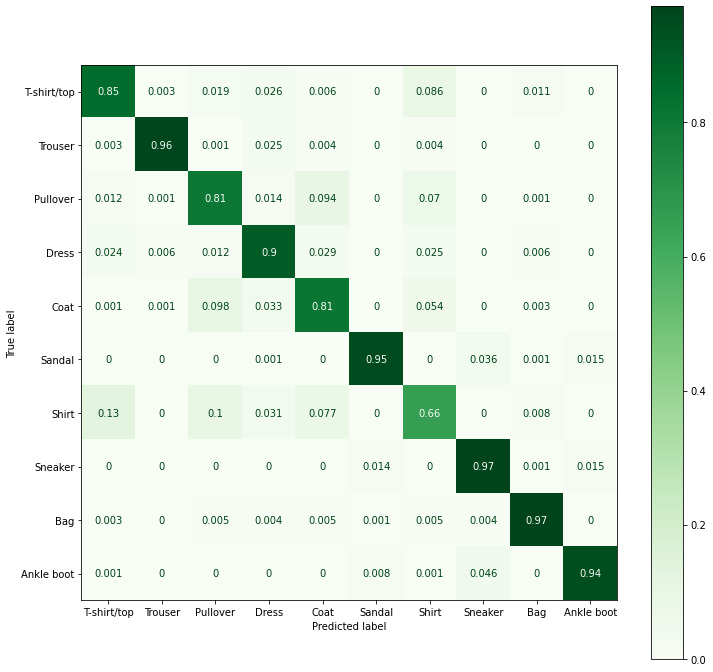

The accuracy on test data is: 0.8817


In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
def predict_test(X_test,Y_test,W,b,n_neurons,n_layers,activation_function,n_outputneurons,plotconfusion=False):
  test_f=[X_test[i].flatten() for i in range(X_test.shape[0])]
  test_f=np.transpose(test_f)
  #calculating prediction scores on the test data using the model learned
  yt_pred=forwardPropagation(W,b,n_neurons,n_layers,activation_function,test_f,n_outputneurons)
  #calculating accuracy
  test_acc=calc_accuracy(yt_pred,Y_test)
  y_pred = np.argmax(yt_pred["y"],axis=0)
  if(plotconfusion):
    #plot function for confusion matrix
    plot_conf_matrix(y_pred,Y_test)
  
  return test_acc

cross_acc=predict_test(X_test,Y_test,W,b,128,3,"relu",10,True)
print("The accuracy on test data is:",cross_acc)


Comparing cross entropy and mse for the best model identified 

___________________________________________________________________
Running Adam.....
epoch        training loss         validation loss               
1         0.01950331656098477      0.020157709578218573          
2         0.017979138273971847     0.018842002574119603          
3         0.016868140173427276     0.018045294487725076          
4         0.016107694109700567     0.017562804057943773          
5         0.015448657666884167     0.017138848136131125          
6         0.01498444101659581      0.016970850207144686          
7         0.014562853019503018     0.01677809347650461           
8         0.01426958111313916      0.016722723323872597          
9         0.013928682480155033     0.01664016890428593           
10        0.013641288057817185     0.016583300723383116          
------------------------------------------------------------------
Accuracy on training data: 0.9085740740740741
Accuracy on validation data: 0.8871666666666667


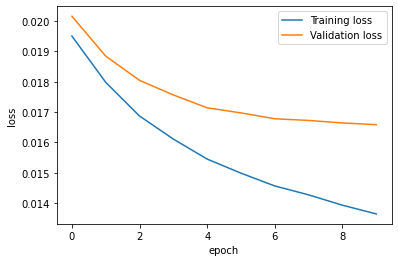

The accuracy on test data using mse is: 0.8756


epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▅▆▆▇▇▇██
validation_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
training_accuracy,0.90857
training_loss,0.01364
validation_accuracy,0.88717
validation_loss,0.01658


In [46]:
run=wandb.init(project="assignment1")
wandb.run.name="mse"
(Loss,W,b,v_mse_loss)=network_train(10,1e-3,3,"relu",128,"xavier",trainData,Y_train,32,0,"adam",784,10,10,0.9,0.9,0.999,1e-8,"mean_squared_error")
mse_acc=predict_test(X_test,Y_test,W,b,128,3,"relu",10)
print("The accuracy on test data using mse is:",mse_acc)
run.finish()